## Dataset

Let's consider the MNIST and SVHN datasets to implement our joint VAE. These datasets can be directly downloaded from the Pytorch vision package.

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

# Define transformations for MNIST to resize to 32x32
mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Load MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

# Load SVHN dataset
svhn_data = datasets.SVHN(root='./data/SVHN', split='train', download=True, transform=transforms.ToTensor())
svhn_loader = DataLoader(svhn_data, batch_size=64, shuffle=True)


Showing 6 samples out of 60000 for: MNIST Samples


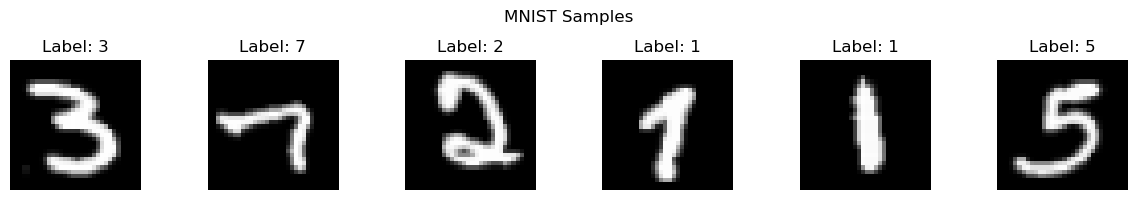

Showing 6 samples out of 73257 for: SVHN Samples


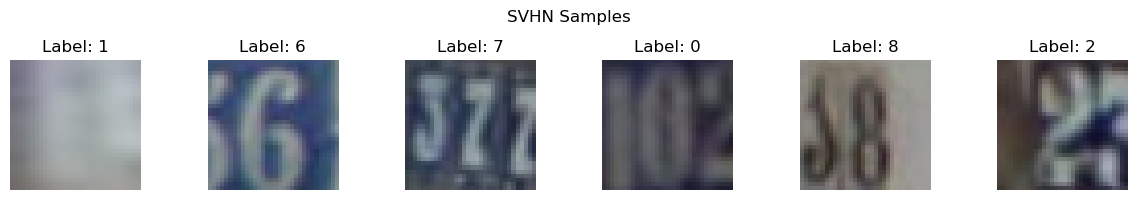

In [2]:
# Visualize some samples from both datasets
import matplotlib.pyplot as plt

def show_samples(data_loader, title, num_samples):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        if images.shape[1] == 1:  # Grayscale image (MNIST)
            axes[i].imshow(images[i].squeeze(), cmap='gray')
        else:  # Color image (SVHN)
            axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')
    print(f"Showing {num_samples} samples out of {len(data_loader.dataset)} for: {title}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(mnist_loader, 'MNIST Samples', num_samples=6)
show_samples(svhn_loader, 'SVHN Samples', num_samples=6)

Now that we have defined our datasets, we can proceed to implement the joint VAE architecture and training procedure. First, let us ensure our **joint** database is correctly set up. That is, for each MNIST image, we need to have a corresponding SVHN image with the same label (digit). This can be achieved by filtering and pairing the datasets based on their labels.

In [3]:
# Filter and pair datasets based on labels
import numpy as np

# Get all labels
mnist_labels = mnist_data.targets.numpy()
svhn_labels = svhn_data.labels

# Create dictionaries mapping labels to indices
mnist_label_to_indices = {label: [] for label in range(10)}
svhn_label_to_indices = {label: [] for label in range(10)}

# Populate the dictionaries
for i, label in enumerate(mnist_labels):
    mnist_label_to_indices[label].append(i)

for i, label in enumerate(svhn_labels):
    svhn_label_to_indices[label].append(i)

paired_mnist_indices = []
paired_svhn_indices = []

# Pair samples with the same label
for label in range(10):
    mnist_indices = mnist_label_to_indices[label]
    svhn_indices = svhn_label_to_indices[label]

    # Pair up to min count
    min_count = min(len(mnist_indices), len(svhn_indices))
    paired_mnist_indices.extend(mnist_indices[:min_count])
    paired_svhn_indices.extend(svhn_indices[:min_count])

print(f"MNIST samples: {len(mnist_labels)}")
print(f"SVHN samples: {len(svhn_labels)}")
print(f"Paired samples: {len(paired_mnist_indices)}")

# Create paired loaders using indices
class PairedDataset(Dataset):
    def __init__(self, dataset1, dataset2, indices1, indices2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.indices1 = indices1
        self.indices2 = indices2
    
    def __len__(self):
        return len(self.indices1)
    
    def __getitem__(self, idx):
        img1, label1 = self.dataset1[self.indices1[idx]]
        img2, label2 = self.dataset2[self.indices2[idx]]
        return img1, img2, label1, label2

paired_dataset = PairedDataset(mnist_data, svhn_data, paired_mnist_indices, paired_svhn_indices)
paired_loader = DataLoader(paired_dataset, batch_size=64, shuffle=True)

# Updated visualization
def show_paired_samples(loader, n_samples):
    images1, images2, labels1, labels2 = next(iter(loader))
    
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(n_samples):
        axes[0, i].imshow(images1[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'MNIST: {labels1[i]}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(images2[i].permute(1, 2, 0))
        axes[1, i].set_title(f'SVHN: {labels2[i]}')
        axes[1, i].axis('off')
    
    plt.suptitle('Paired MNIST and SVHN Samples')
    plt.tight_layout()
    plt.show()

MNIST samples: 60000
SVHN samples: 73257
Paired samples: 56068


We have created a `PairedDataset` class that takes two datasets and pairs samples with matching labels. Note that only 56068 pairs were formed since both datasets do not have the same number of samples for each digit. For each digit, the number of paired samples has an upper bound defined by:

$$\text{Number of pairs} \leq \min(\text{\# MNIST samples}, \text{\# SVHN samples})$$

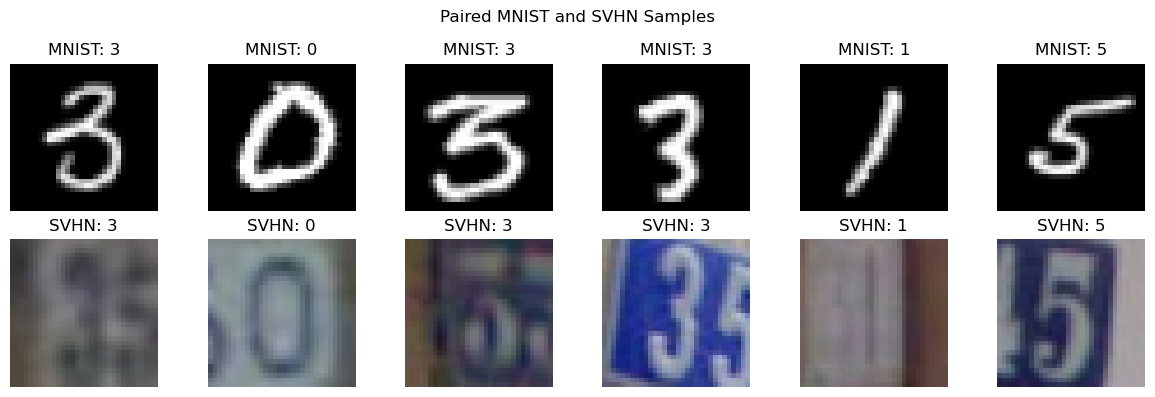

In [4]:
show_paired_samples(paired_loader, 6)

## Multi-View VAE Implementation

Now that we have our paired dataset, we can proceed to implement the multi-view VAE architecture. The joint VAE will consist of separate encoders and decoders for each view (MNIST and SVHN) but will share a common latent space.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Helper functions for reparameterization and Product of Experts
def reparameterize(mu, logvar):
    """
    Reparameterization trick: z = mu + std * epsilon
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def product_of_experts(mu1, logvar1, mu2, logvar2):
    """
    Combines two Gaussian experts using Product of Experts.
    Returns the parameters (mu, logvar) of the joint distribution.
    Assumes diagonal covariance matrices.
    """
    var1 = torch.exp(logvar1)
    var2 = torch.exp(logvar2)

    # Precision is inverse variance
    precision1 = 1.0 / var1
    precision2 = 1.0 / var2

    # Joint precision is sum of precisions
    joint_precision = precision1 + precision2

    # Joint variance is inverse of joint precision
    joint_var = 1.0 / joint_precision

    # Joint mean is precision-weighted sum of means
    joint_mu = (mu1 * precision1 + mu2 * precision2) * joint_var

    # Joint log variance
    joint_logvar = torch.log(joint_var)

    return joint_mu, joint_logvar

# Encoder architecture(s) using simple CNNs
class MNISTEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(MNISTEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class SVHNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(SVHNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Decoder architecture(s) using simple CNNs
class MNISTDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(MNISTDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 64 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)   
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)   
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(16)

    # Forward pass
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 64, 4, 4)
        z = F.relu(self.bn1(self.deconv1(z)))
        z = F.relu(self.bn2(self.deconv2(z)))
        x_recon = torch.sigmoid(self.deconv3(z))
        return x_recon

class SVHNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(SVHNDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 64 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1) 
        self.deconv3 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)    
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(16)

    # Forward pass
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 64, 4, 4)
        z = F.relu(self.bn1(self.deconv1(z)))
        z = F.relu(self.bn2(self.deconv2(z)))
        x_recon = torch.sigmoid(self.deconv3(z))
        return x_recon

Now that we have defined our helper functions and encoder/decoder architectures, we can proceed to implement the training loop for our multi-view VAE. The training process involves optimizing the combined loss function that includes reconstruction losses for both views and the KL divergence term.

In [6]:
# Multi-View VAE Model
class MultiViewVAE(nn.Module):
    def __init__(self, latent_dim):
        super(MultiViewVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_mnist = MNISTEncoder(latent_dim)
        self.encoder_svhn = SVHNEncoder(latent_dim)
        self.decoder_mnist = MNISTDecoder(latent_dim)
        self.decoder_svhn = SVHNDecoder(latent_dim)

    # Forward pass
    def forward(self, x_mnist, x_svhn):
        # Encode each modality
        mu_mnist, logvar_mnist = self.encoder_mnist(x_mnist)
        mu_svhn, logvar_svhn = self.encoder_svhn(x_svhn)

        # Combine using Product of Experts to get joint posterior parameters
        mu_joint, logvar_joint = product_of_experts(
            mu_mnist, logvar_mnist, mu_svhn, logvar_svhn
        )

        # Sample from the joint posterior using reparameterization trick
        z_joint = reparameterize(mu_joint, logvar_joint)

        # Decode using the joint latent variable
        x_recon_mnist = self.decoder_mnist(z_joint)
        x_recon_svhn = self.decoder_svhn(z_joint)

        return (
            x_recon_mnist,
            x_recon_svhn,
            mu_joint,
            logvar_joint,
            mu_mnist,
            logvar_mnist, 
            mu_svhn,
            logvar_svhn,
        )

    def generate(self, z):
        """Generate samples from latent variable z"""
        self.eval()  # Put model in evaluation mode
        with torch.no_grad():
            x_gen_mnist = self.decoder_mnist(z)
            x_gen_svhn = self.decoder_svhn(z)
        return x_gen_mnist, x_gen_svhn

    def reconstruct_cross(self, x_mnist=None, x_svhn=None):
        """Reconstruct one modality given the other"""
        self.eval()
        with torch.no_grad():
            if x_mnist is not None and x_svhn is None:
                # Use MNIST encoder to get latent z, then decode with SVHN decoder
                mu, logvar = self.encoder_mnist(x_mnist)
                z = reparameterize(mu, logvar)  # Could also just use mu
                x_cross_svhn = self.decoder_svhn(z)
                x_recon_mnist = self.decoder_mnist(z)  # Reconstruct original
                return x_recon_mnist, x_cross_svhn
            elif x_svhn is not None and x_mnist is None:
                # Use SVHN encoder to get latent z, then decode with MNIST decoder
                mu, logvar = self.encoder_svhn(x_svhn)
                z = reparameterize(mu, logvar)  # Could also just use mu
                x_cross_mnist = self.decoder_mnist(z)
                x_recon_svhn = self.decoder_svhn(z)  # Also reconstruct original
                return x_cross_mnist, x_recon_svhn
            else:
                raise ValueError(
                    "Provide exactly one input modality (x_mnist or x_svhn)"
                )

We now define the loss function for the multi-view VAE. The loss consists of three components: the reconstruction loss for the MNIST view, the reconstruction loss for the SVHN view, and the KL divergence loss that regularizes the latent space.

In [13]:
def vae_loss(
    x_recon_mnist=None, x_mnist=None, 
    x_recon_svhn=None, x_svhn=None, 
    mu=None, logvar=None, 
    beta=1.0
):
    """
    Computes the VAE loss.
    Handles Joint, MNIST-only, and SVHN-only cases by checking the provided inputs.
    """
    loss = 0
    batch_size = 1
    device = None

    # Determine batch size and device from available inputs
    if x_mnist is not None:
        batch_size = x_mnist.size(0)
        device = x_mnist.device
    elif x_svhn is not None:
        batch_size = x_svhn.size(0)
        device = x_svhn.device
    
    # MNIST Reconstruction (BCE)
    if x_recon_mnist is not None and x_mnist is not None:
        recon_loss_mnist = F.binary_cross_entropy(
            x_recon_mnist.reshape(x_mnist.size(0), -1),
            x_mnist.reshape(x_mnist.size(0), -1),
            reduction="sum",
        )
        loss += recon_loss_mnist
    else:
        recon_loss_mnist = torch.tensor(0.0, device=device)

    # SVHN Reconstruction (MSE)
    if x_recon_svhn is not None and x_svhn is not None:
        recon_loss_svhn = F.mse_loss(
            x_recon_svhn.reshape(x_svhn.size(0), -1),
            x_svhn.reshape(x_svhn.size(0), -1),
            reduction="sum",
        )
        loss += recon_loss_svhn
    else:
        recon_loss_svhn = torch.tensor(0.0, device=device)

    # KL Divergence
    if mu is not None and logvar is not None:
        kl_div = 0.5 * torch.sum(mu.pow(2) + torch.exp(logvar) - 1 - logvar)
        loss += beta * kl_div
    else:
        kl_div = torch.tensor(0.0, device=device)

    return (
        loss / batch_size,
        recon_loss_mnist / batch_size,
        recon_loss_svhn / batch_size,
        kl_div / batch_size,
    )

Everything is now set up to train our multi-view VAE on the paired MNIST and SVHN datasets. We will train the model for a specified number of epochs, monitoring the loss to ensure that the model is learning effectively.

Train Epoch: 0 [0/56068 (0%)]	Loss: 1914.011841 ReconM: 789.5076 ReconS: 165.5519 KLD: 1.9776
Train Epoch: 0 [6400/56068 (11%)]	Loss: 869.534668 ReconM: 363.9604 ReconS: 62.8284 KLD: 9.4299
Train Epoch: 0 [12800/56068 (23%)]	Loss: 626.780151 ReconM: 255.7949 ReconS: 43.0969 KLD: 14.8320
Train Epoch: 0 [19200/56068 (34%)]	Loss: 557.006470 ReconM: 216.8927 ReconS: 41.9702 KLD: 19.1196
Train Epoch: 0 [25600/56068 (46%)]	Loss: 488.086945 ReconM: 186.1599 ReconS: 37.2213 KLD: 20.9965
Train Epoch: 0 [32000/56068 (57%)]	Loss: 428.742188 ReconM: 158.8568 ReconS: 33.8729 KLD: 21.6406
Train Epoch: 0 [38400/56068 (68%)]	Loss: 447.339172 ReconM: 161.6181 ReconS: 39.2833 KLD: 22.2009
Train Epoch: 0 [44800/56068 (80%)]	Loss: 450.329926 ReconM: 158.4377 ReconS: 41.6898 KLD: 24.0354
Train Epoch: 0 [51200/56068 (91%)]	Loss: 404.701996 ReconM: 146.8024 ReconS: 32.1156 KLD: 23.6846
====> Epoch: 0 Average loss: 576.9833


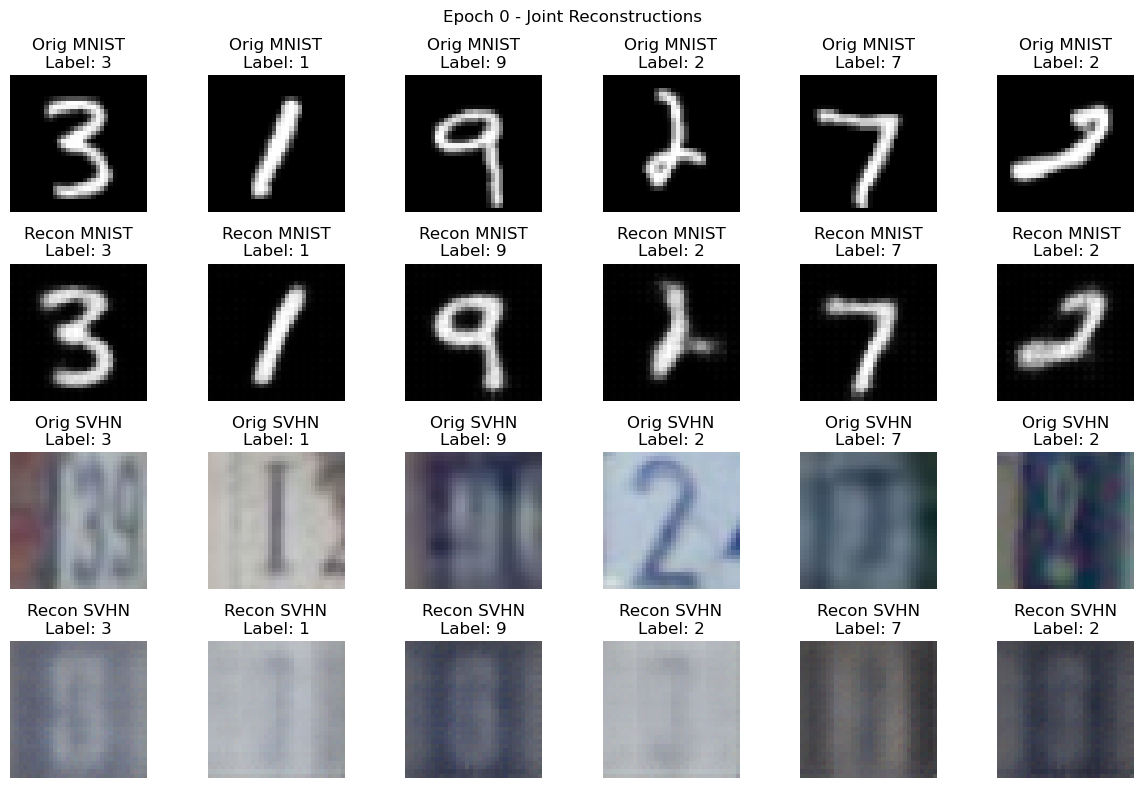

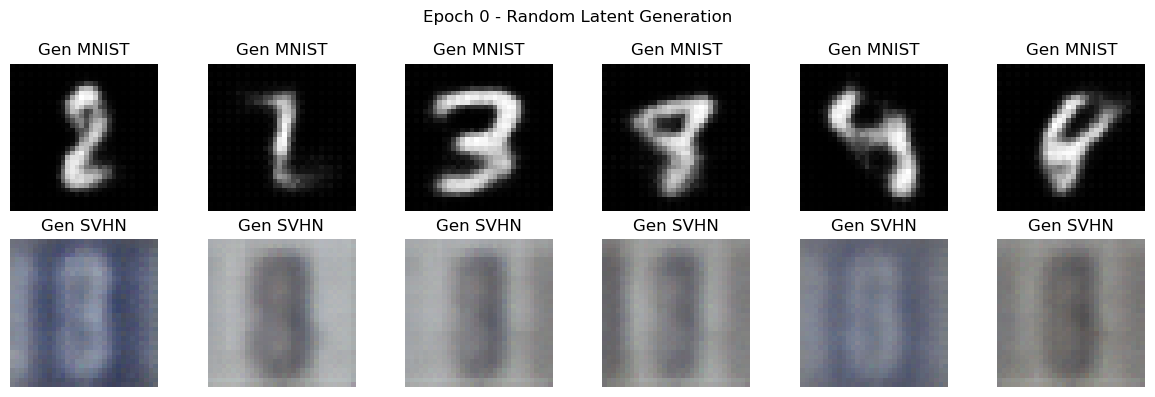

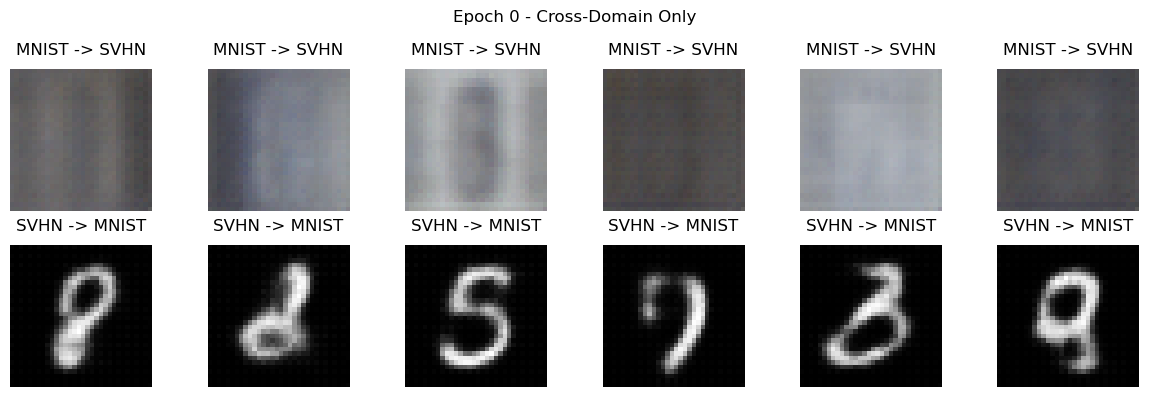

Train Epoch: 1 [0/56068 (0%)]	Loss: 432.078156 ReconM: 152.1235 ReconS: 40.3675 KLD: 23.6271
Train Epoch: 1 [6400/56068 (11%)]	Loss: 425.988739 ReconM: 152.3814 ReconS: 34.4411 KLD: 26.1546
Train Epoch: 1 [12800/56068 (23%)]	Loss: 394.031036 ReconM: 136.3290 ReconS: 35.2404 KLD: 25.1134
Train Epoch: 1 [19200/56068 (34%)]	Loss: 408.555176 ReconM: 143.6275 ReconS: 34.3210 KLD: 25.8465
Train Epoch: 1 [25600/56068 (46%)]	Loss: 403.679443 ReconM: 133.4313 ReconS: 42.6770 KLD: 25.8170
Train Epoch: 1 [32000/56068 (57%)]	Loss: 368.306213 ReconM: 131.7901 ReconS: 26.3982 KLD: 25.1822
Train Epoch: 1 [38400/56068 (68%)]	Loss: 412.551880 ReconM: 140.4414 ReconS: 38.7231 KLD: 26.8972
Train Epoch: 1 [44800/56068 (80%)]	Loss: 380.320465 ReconM: 136.1905 ReconS: 27.0074 KLD: 27.2851
Train Epoch: 1 [51200/56068 (91%)]	Loss: 411.040741 ReconM: 140.2097 ReconS: 37.1992 KLD: 27.3171
====> Epoch: 1 Average loss: 401.5913
Train Epoch: 2 [0/56068 (0%)]	Loss: 378.633301 ReconM: 132.1560 ReconS: 30.4600 KLD: 2

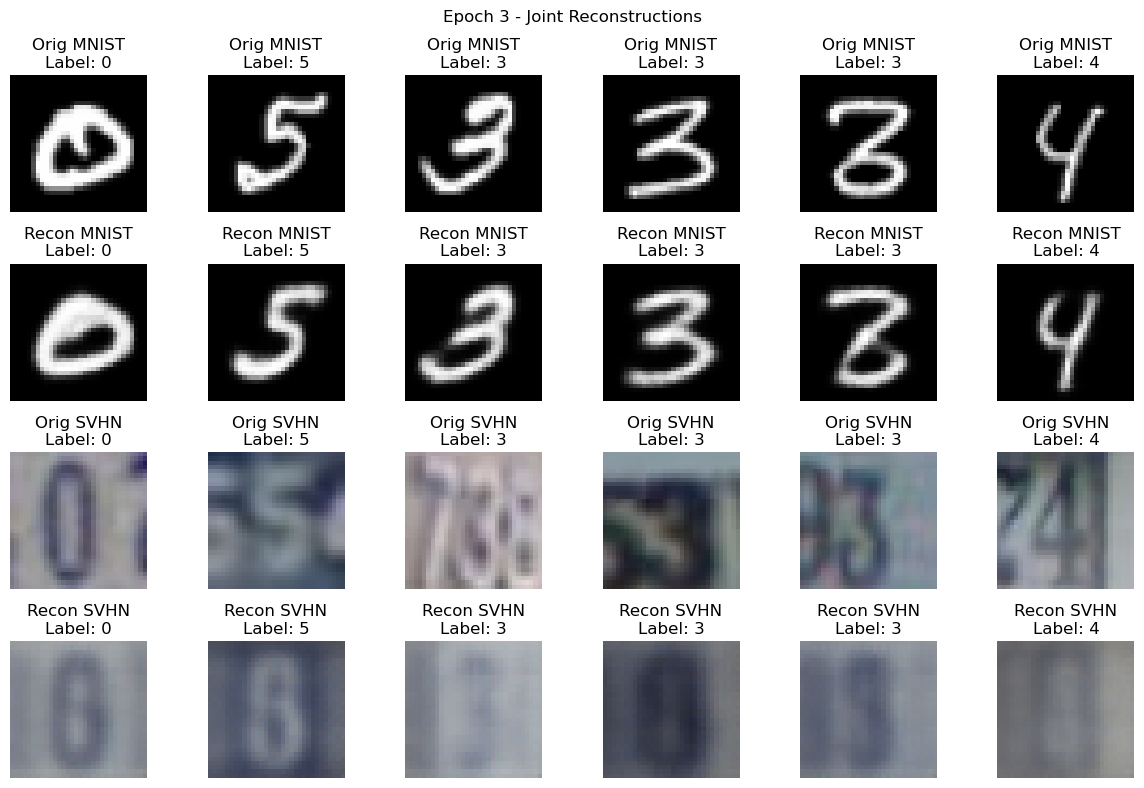

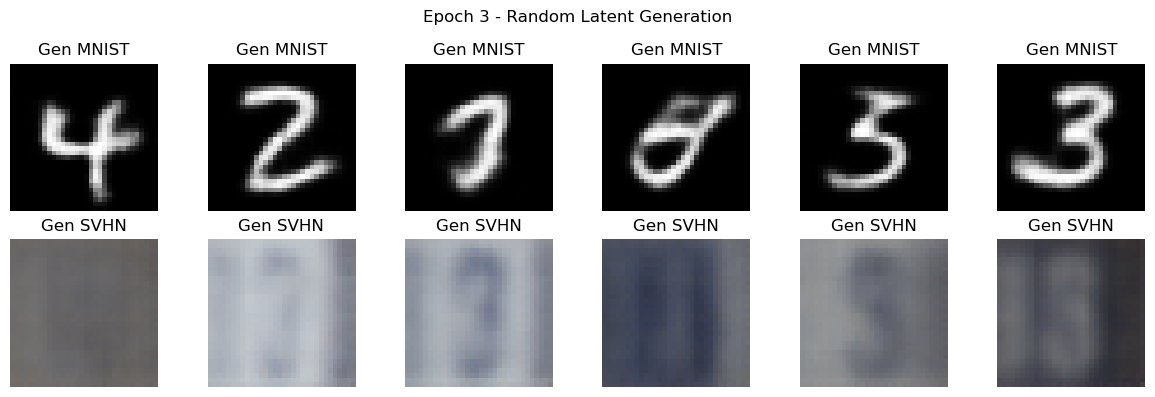

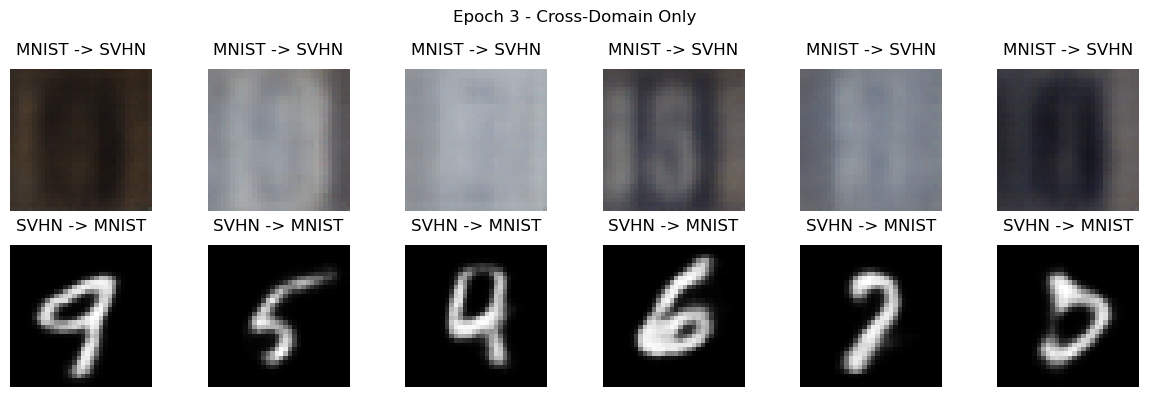

Train Epoch: 4 [0/56068 (0%)]	Loss: 373.721680 ReconM: 129.6411 ReconS: 29.2876 KLD: 27.4308
Train Epoch: 4 [6400/56068 (11%)]	Loss: 391.367889 ReconM: 133.0712 ReconS: 34.1141 KLD: 27.8207
Train Epoch: 4 [12800/56068 (23%)]	Loss: 374.786041 ReconM: 128.1011 ReconS: 31.1821 KLD: 27.3209
Train Epoch: 4 [19200/56068 (34%)]	Loss: 370.460388 ReconM: 130.9535 ReconS: 25.7978 KLD: 28.2384
Train Epoch: 4 [25600/56068 (46%)]	Loss: 386.647675 ReconM: 131.6012 ReconS: 33.6949 KLD: 27.7653
Train Epoch: 4 [32000/56068 (57%)]	Loss: 369.856232 ReconM: 127.6690 ReconS: 28.6515 KLD: 28.0573
Train Epoch: 4 [38400/56068 (68%)]	Loss: 359.051270 ReconM: 123.8725 ReconS: 28.0906 KLD: 27.1758
Train Epoch: 4 [44800/56068 (80%)]	Loss: 381.681854 ReconM: 132.7619 ReconS: 30.1349 KLD: 27.1398
Train Epoch: 4 [51200/56068 (91%)]	Loss: 377.106079 ReconM: 133.6236 ReconS: 27.3423 KLD: 28.0820
====> Epoch: 4 Average loss: 378.9334
Train Epoch: 5 [0/56068 (0%)]	Loss: 383.775360 ReconM: 129.0042 ReconS: 33.7586 KLD: 2

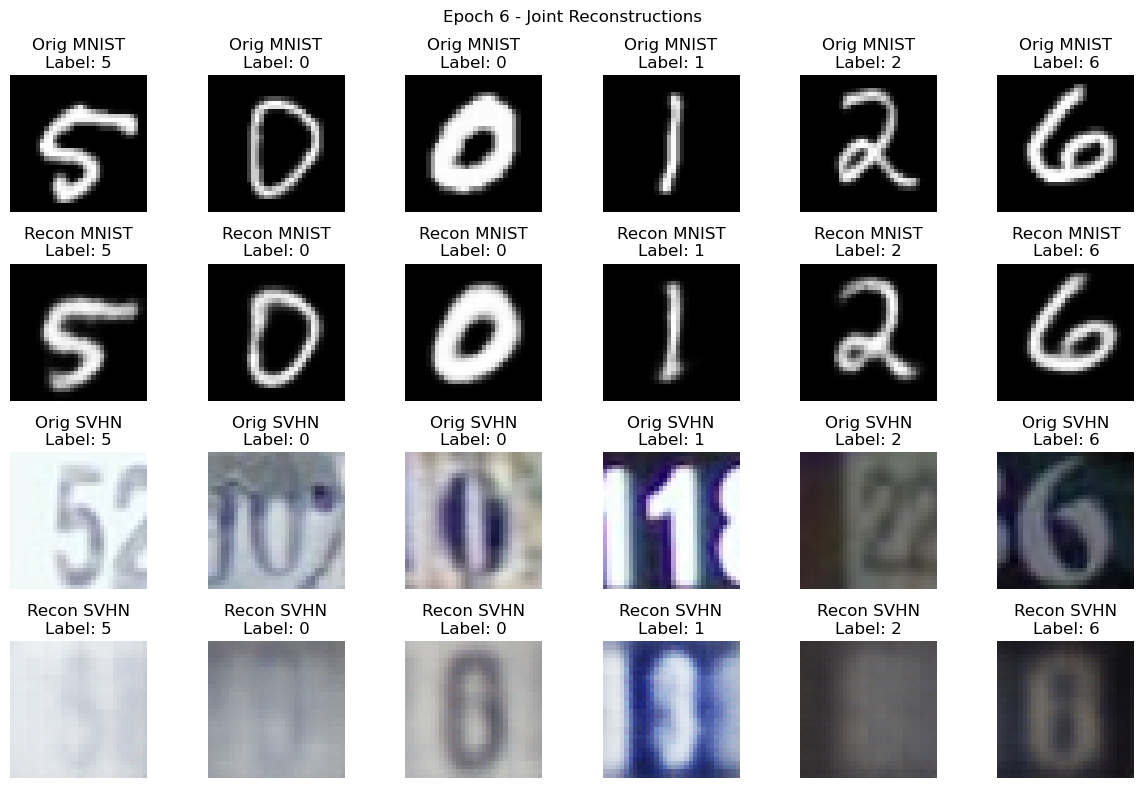

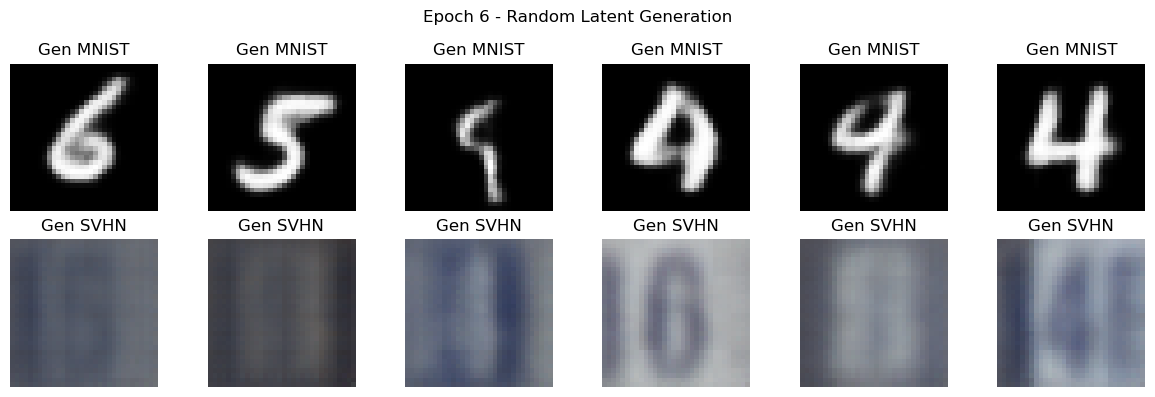

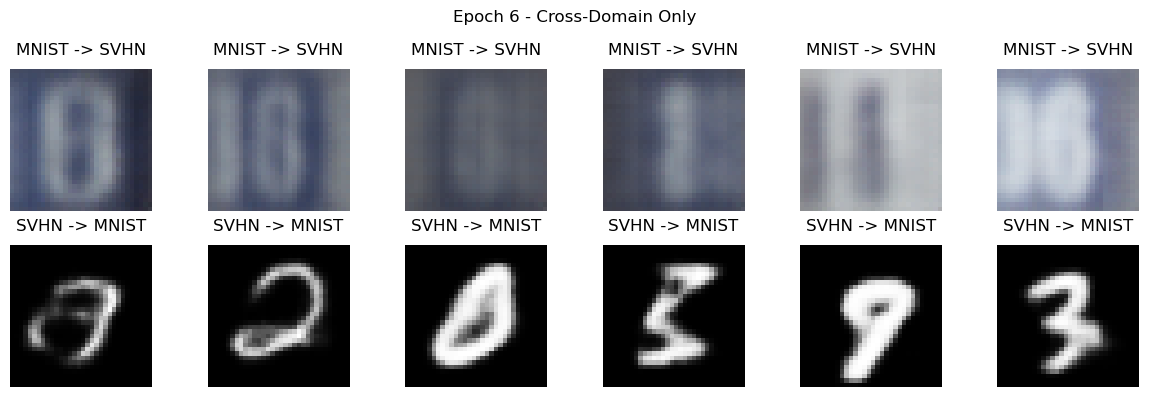

Train Epoch: 7 [0/56068 (0%)]	Loss: 377.432007 ReconM: 126.6791 ReconS: 33.5637 KLD: 28.0212
Train Epoch: 7 [6400/56068 (11%)]	Loss: 379.626831 ReconM: 127.6540 ReconS: 33.4398 KLD: 28.5115
Train Epoch: 7 [12800/56068 (23%)]	Loss: 367.245850 ReconM: 125.8417 ReconS: 29.0573 KLD: 28.2881
Train Epoch: 7 [19200/56068 (34%)]	Loss: 368.273071 ReconM: 128.6005 ReconS: 26.9627 KLD: 28.1169
Train Epoch: 7 [25600/56068 (46%)]	Loss: 362.430725 ReconM: 122.3744 ReconS: 29.2729 KLD: 28.6122
Train Epoch: 7 [32000/56068 (57%)]	Loss: 363.347473 ReconM: 123.8452 ReconS: 29.9458 KLD: 28.4883
Train Epoch: 7 [38400/56068 (68%)]	Loss: 352.437622 ReconM: 122.4990 ReconS: 24.9888 KLD: 28.5896
Train Epoch: 7 [44800/56068 (80%)]	Loss: 397.748566 ReconM: 128.5696 ReconS: 40.4732 KLD: 29.4586
Train Epoch: 7 [51200/56068 (91%)]	Loss: 359.640778 ReconM: 122.0435 ReconS: 30.9306 KLD: 27.6313
====> Epoch: 7 Average loss: 371.8271
Train Epoch: 8 [0/56068 (0%)]	Loss: 364.353699 ReconM: 126.6647 ReconS: 25.9635 KLD: 2

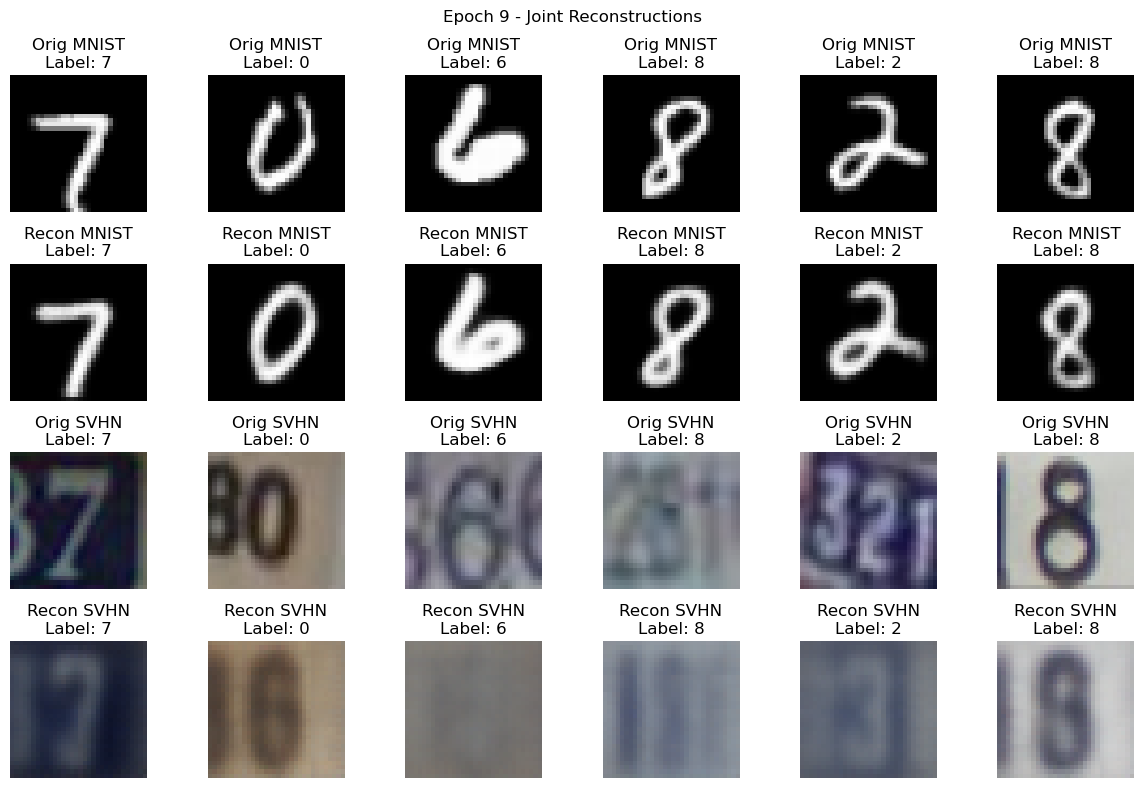

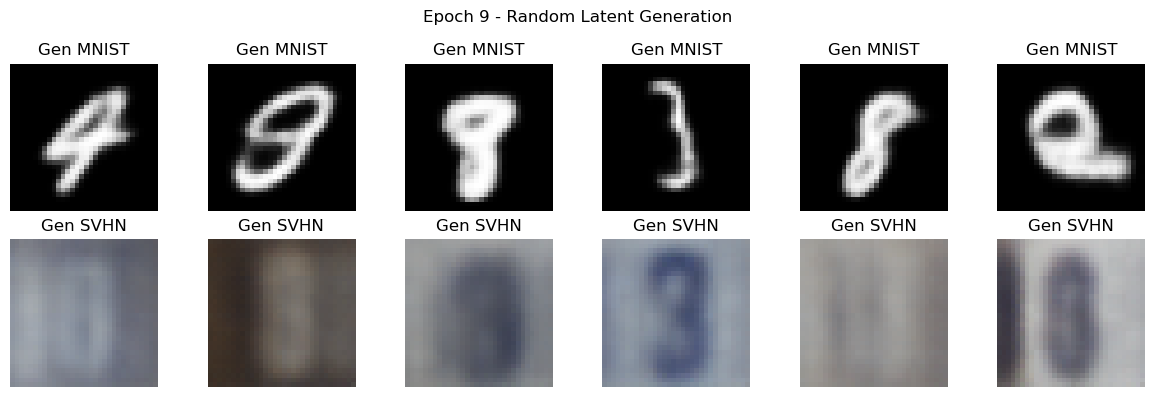

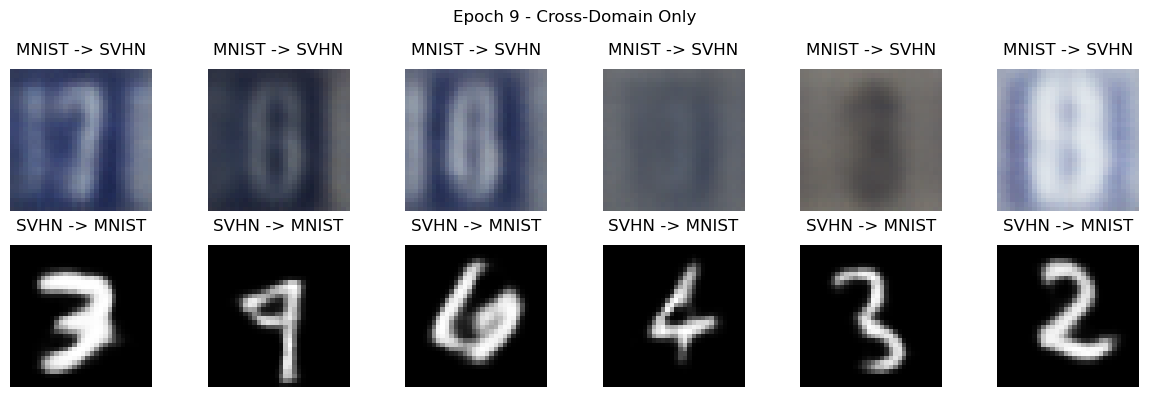

Train Epoch: 10 [0/56068 (0%)]	Loss: 361.869751 ReconM: 126.8280 ReconS: 25.4567 KLD: 28.0893
Train Epoch: 10 [6400/56068 (11%)]	Loss: 371.471375 ReconM: 125.9016 ReconS: 30.5304 KLD: 29.1710
Train Epoch: 10 [12800/56068 (23%)]	Loss: 389.759155 ReconM: 131.4792 ReconS: 33.6928 KLD: 29.4235
Train Epoch: 10 [19200/56068 (34%)]	Loss: 369.662994 ReconM: 126.3914 ReconS: 28.8894 KLD: 29.1866
Train Epoch: 10 [25600/56068 (46%)]	Loss: 359.812073 ReconM: 120.0817 ReconS: 31.0519 KLD: 28.9258
Train Epoch: 10 [32000/56068 (57%)]	Loss: 360.621887 ReconM: 126.3697 ReconS: 25.2533 KLD: 29.0143
Train Epoch: 10 [38400/56068 (68%)]	Loss: 385.983673 ReconM: 133.9709 ReconS: 27.6898 KLD: 30.2202
Train Epoch: 10 [44800/56068 (80%)]	Loss: 364.436890 ReconM: 127.2143 ReconS: 25.4719 KLD: 29.3791
Train Epoch: 10 [51200/56068 (91%)]	Loss: 378.582245 ReconM: 129.6380 ReconS: 29.9241 KLD: 29.9556
====> Epoch: 10 Average loss: 367.8774
Train Epoch: 11 [0/56068 (0%)]	Loss: 366.720917 ReconM: 126.6822 ReconS: 26.

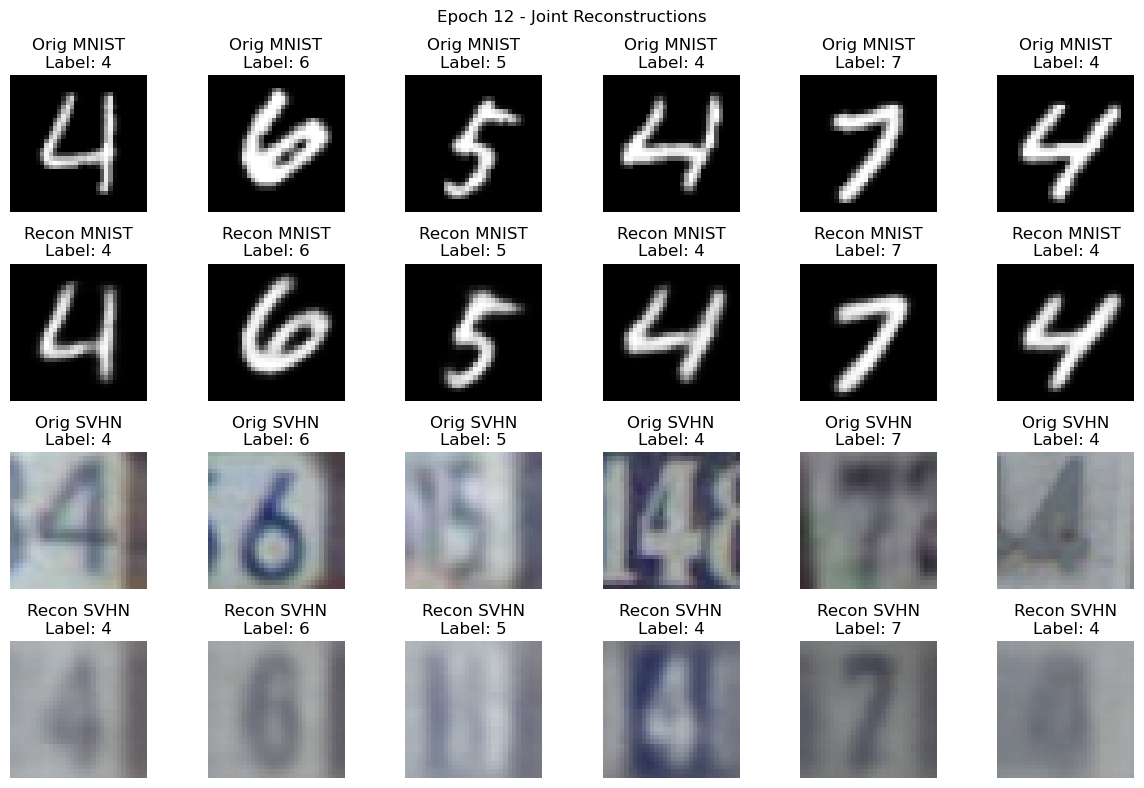

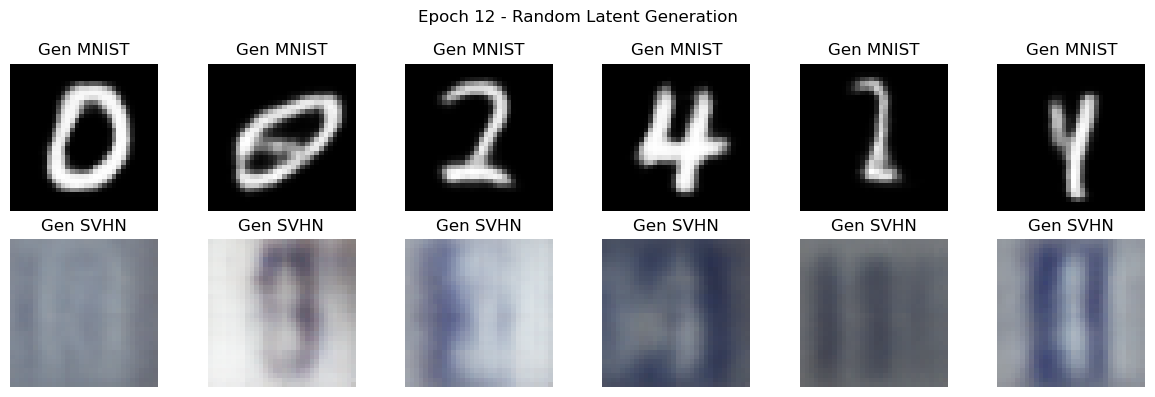

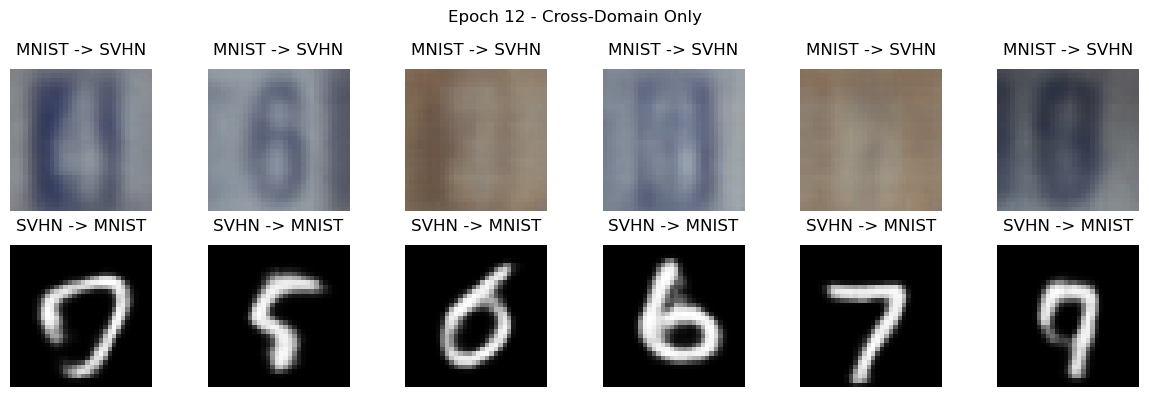

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 20
model = MultiViewVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 12  # Number of epochs

for epoch in range(num_epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (mnist_batch, svhn_batch, _, _) in enumerate(paired_loader):
        mnist_batch = mnist_batch.to(device)
        svhn_batch = svhn_batch.to(device)

        optimizer.zero_grad()

        # Joint forward pass
        recon_m, recon_s, mu_joint, logvar_joint, mu_m, logvar_m, mu_s, logvar_s = model(mnist_batch, svhn_batch)
        
        # Joint Loss
        loss_joint, recon_m_loss, recon_s_loss, kld_joint = vae_loss(
            x_recon_mnist=recon_m, x_mnist=mnist_batch, 
            x_recon_svhn=recon_s, x_svhn=svhn_batch, 
            mu=mu_joint, logvar=logvar_joint, beta=1.0
        )

        # MNIST forward pass 
        z_m = reparameterize(mu_m, logvar_m)
        recon_m_from_m = model.decoder_mnist(z_m)
        
        # MNIST-Only Loss
        loss_mnist, _, _, _ = vae_loss(
            x_recon_mnist=recon_m_from_m, x_mnist=mnist_batch,
            mu=mu_m, logvar=logvar_m, beta=1.0
        )

        # SVHN forward pass 
        z_s = reparameterize(mu_s, logvar_s)
        recon_s_from_s = model.decoder_svhn(z_s)
        
        # SVHN-Only Loss
        loss_svhn, _, _, _ = vae_loss(
            x_recon_svhn=recon_s_from_s, x_svhn=svhn_batch,
            mu=mu_s, logvar=logvar_s, beta=1
        )

        # Total loss
        loss = loss_joint + loss_mnist + loss_svhn

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(mnist_batch)}/{len(paired_loader.dataset)} '
                  f'({100. * batch_idx / len(paired_loader):.0f}%)]\tLoss: {loss.item():.6f} '
                  f'ReconM: {recon_m_loss.item():.4f} ReconS: {recon_s_loss.item():.4f} KLD: {kld_joint.item():.4f}')

    avg_loss = train_loss / len(paired_loader)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')

    # Sample generation and visualization
    if epoch % 3 == 0:  # Every 3 epochs
        model.eval()
        with torch.no_grad():
            # Generate random samples from standard normal
            z_sample = torch.randn(6, latent_dim).to(device)
            x_gen_mnist, x_gen_svhn = model.generate(z_sample)
            
            # Get reconstructions from first batch
            mnist_batch, svhn_batch, mnist_batch_labels, svhn_batch_labels = next(iter(paired_loader))
            mnist_batch = mnist_batch.to(device)
            svhn_batch = svhn_batch.to(device)
            recon_m, recon_s, _, _, _, _, _, _ = model(mnist_batch, svhn_batch)

            # Cross-domain reconstruction (MNIST->SVHN and SVHN->MNIST)
            cross_mnist, cross_svhn = model.reconstruct_cross(x_mnist=mnist_batch)
            cross_svhn_to_mnist, cross_mnist_gen = model.reconstruct_cross(x_svhn=svhn_batch)
            
            # Visualize reconstructions with labels
            fig, axes = plt.subplots(4, 6, figsize=(12, 8))
            for i in range(6):
                # Original MNIST
                axes[0, i].imshow(mnist_batch[i].cpu().squeeze(), cmap='gray')
                axes[0, i].set_title(f'Orig MNIST\nLabel: {mnist_batch_labels[i]}')
                axes[0, i].axis('off')
                
                # Reconstructed MNIST
                axes[1, i].imshow(recon_m[i].cpu().squeeze(), cmap='gray')
                axes[1, i].set_title(f'Recon MNIST\nLabel: {mnist_batch_labels[i]}')
                axes[1, i].axis('off')
                
                # Original SVHN
                axes[2, i].imshow(svhn_batch[i].cpu().permute(1, 2, 0))
                axes[2, i].set_title(f'Orig SVHN\nLabel: {svhn_batch_labels[i]}')
                axes[2, i].axis('off')
                
                # Reconstructed SVHN
                axes[3, i].imshow(recon_s[i].cpu().permute(1, 2, 0))
                axes[3, i].set_title(f'Recon SVHN\nLabel: {svhn_batch_labels[i]}')
                axes[3, i].axis('off')

            plt.suptitle(f'Epoch {epoch} - Joint Reconstructions')
            plt.tight_layout()
            plt.show()
            
            # Generated samples
            fig, axes = plt.subplots(2, 6, figsize=(12, 4))
            for i in range(6):
                axes[0, i].imshow(x_gen_mnist[i].cpu().squeeze(), cmap='gray')
                axes[0, i].set_title('Gen MNIST')
                axes[0, i].axis('off')
                
                axes[1, i].imshow(x_gen_svhn[i].cpu().permute(1, 2, 0))
                axes[1, i].set_title('Gen SVHN')
                axes[1, i].axis('off')
            
            plt.suptitle(f'Epoch {epoch} - Random Latent Generation')
            plt.tight_layout()
            plt.show()

            # Cross-domain generation 
            fig, axes = plt.subplots(2, 6, figsize=(12, 4))

            for i in range(6):
                # Row 1: MNIST -> SVHN
                axes[0, i].imshow(cross_svhn[i].cpu().permute(1, 2, 0).clamp(0, 1))
                axes[0, i].set_title(f'MNIST -> SVHN', pad=10)
                axes[0, i].axis('off')

                # Row 2: SVHN -> MNIST
                axes[1, i].imshow(cross_svhn_to_mnist[i].cpu().squeeze(), cmap='gray')
                axes[1, i].set_title(f'SVHN -> MNIST', pad=10)
                axes[1, i].axis('off')

            plt.suptitle(f'Epoch {epoch} - Cross-Domain Only', y=0.98)
            plt.tight_layout()
            plt.show()

        model.train()

We have generated reconstructions, random latent generations, and cross-domain generations after each epoch to visualize the model's performance. The results show how well the model can reconstruct inputs from both views and generate new samples by sampling from the latent space.

Finally, we will visualize our latent space using t-SNE to see how well the model has learned to cluster the different digit classes in the shared latent space. This will help us understand how effectively the multi-view VAE has captured the underlying structure of the data across both views.

  File "c:\Users\javat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\javat\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\javat\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\javat\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


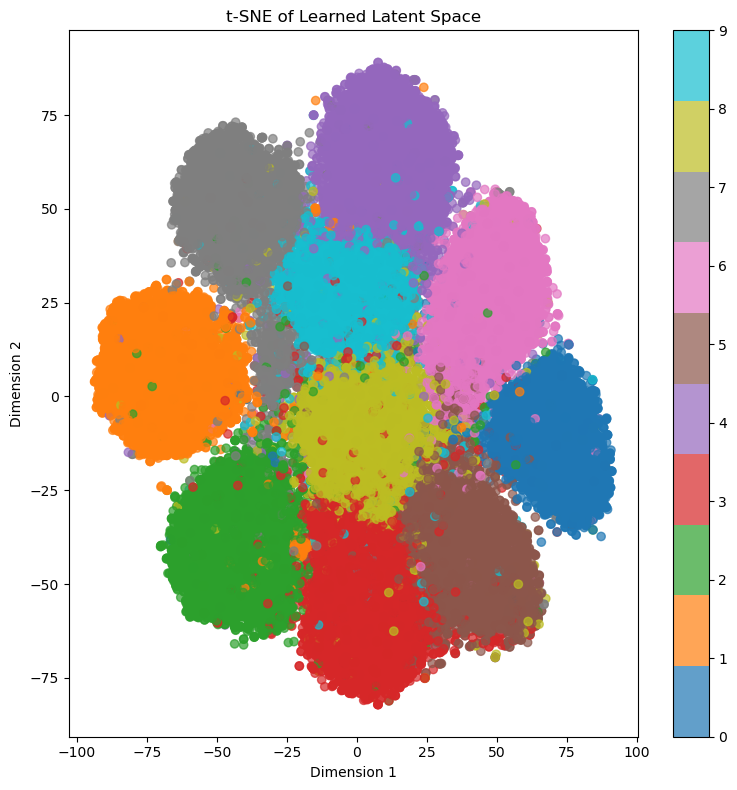

In [19]:
# Visualize learned latent space with t-SNE
from sklearn.manifold import TSNE
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)

def visualize_latent_space(model, data_loader, device):
    # Extract latent representations
    model.eval()
    latents = []
    labels = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for mnist_batch, svhn_batch, mnist_labels, svhn_labels in data_loader:
            mnist_batch = mnist_batch.to(device)
            svhn_batch = svhn_batch.to(device)

            mu_joint, logvar_joint = model.encoder_mnist(mnist_batch)
            mu_svhn, logvar_svhn = model.encoder_svhn(svhn_batch)
            mu_combined, logvar_combined = product_of_experts(mu_joint, logvar_joint, mu_svhn, logvar_svhn)

            latents.append(mu_combined.cpu().numpy())
            labels.append(mnist_labels.numpy()) 

    # Concatenate all batches
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('t-SNE of Learned Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    plt.show()

visualize_latent_space(model, paired_loader, device)